<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Dynamic systems: 8. Elastic material 
## Plate in hole with `solidDisplacementFoam`
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

**In this notebook, we will learn to**

- calculate stresses and displacements in an **elastic plate with a hole**,
using `solidDisplacementFoam` as solver. 

**Prerequisites:** (text)

**Result:** You should get a figure similar to
<img src="images/plateDx.jpg" style=width:10cm>

<a href="#top">**Table of contents**</a>

1. [Solver and equations](#one)
2. [Implementation](#two)
3. [Running](#three)
4. [Post-processing](#four)
5. [Technical aspects](#five)

<div id="one"></div>

----
## 1. Solver and equations

`solidDisplacementFoam` is a 

- transient
- incompressible

solver for the continuity and momentum equations:
$$
\begin{array}{rcl}
\frac{\partial^2 \rho \vec{r}}{\partial t^2} &=& \nabla \cdot \mathbb{\sigma} \\
\mathbb{\sigma} &=& 2 \mu \mathbb{\epsilon} + \lambda tr(\mathbb{\epsilon}) \mathbb{I} \\
\mathbb{\epsilon} &=& \frac{1}{2} \left[ \nabla \vec{r} + (\nabla \vec{r})^T \right]
\end{array}
$$
with
$\vec{r}$ [m] the displacement,
$\mathbb{\sigma}$ [Pa] the Cauchy stress tensor,
$\mathbb{\epsilon}$ [-] the strain tensor,
$\mathbb{I}$ [-] the unity tensor,
$\rho$ [kg/m$^3$] density,
$\lambda$ [Pa] first Lame parameterm
$\mu$ [Pa] second Lame parameter (shear modulus),
$t$ [s] time,
$\nabla$ [1/m] Nabla operator.

On input first and second Lame parameters are defined as Young modulus $E$ [Pa] and
Poisson ratio $\nu$ [-]:
$$
\begin{array}{rcl}
E &=& \frac{\mu (3\lambda + 2\mu)}{\lambda + \mu} \\
\nu &=& \frac{\lambda}{2(\lambda + \mu)}
\end{array}
$$

The equations are then solved by `solidDisplacementFoam`.

**NOTE: `solidDisplacementFoam` returns not stresses, but stress times density!** no longer true ...

<div id="two"></div>

----
## 2.  Implementation

We consider a block with 4m side length, and a hole in the center with $a=0.5$m radius.
The stress is applied in the normal direction of the eastern and western (left and right) faces,
$\sigma_{xx}$ [Pa].
<img src="images/PlateInHole.jpg" style=width:15cm>

As the problem is symmetric with respect to the origin of the hole, 
we only need to consider a quarter of the domain,
with symmetry boundary conditions.

### Directory structure and files

~~~
PlateHole_solidDisplacementFoam
|-- 0
  |-- D
  |-- T
|- constant
  |-- mechanicalProperties
  |-- thermalProperties
|- system
  |-- blockMesh
  |-- controlDict
  |-- fvSchemes
  |-- fvSolution
~~~

- `system/blockMeshDict`
(text)

<details><summary><b>> Show code</b></summary>

~~~
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    object      blockMeshDict;
}
    
convertToMeters 1;

vertices
(
    (0.5 0 0)
    (1 0 0)
    (2 0 0)
    (2 0.707107 0)
    (0.707107 0.707107 0)
    (0.353553 0.353553 0)
    (2 2 0)
    (0.707107 2 0)
    (0 2 0)
    (0 1 0)
    (0 0.5 0)
    (0.5 0 0.5)
    (1 0 0.5)
    (2 0 0.5)
    (2 0.707107 0.5)
    (0.707107 0.707107 0.5)
    (0.353553 0.353553 0.5)
    (2 2 0.5)
    (0.707107 2 0.5)
    (0 2 0.5)
    (0 1 0.5)
    (0 0.5 0.5)
);

blocks
(
    hex (5 4 9 10 16 15 20 21) (10 10 1) simpleGrading (1 1 1)
    hex (0 1 4 5 11 12 15 16) (10 10 1) simpleGrading (1 1 1)
    hex (1 2 3 4 12 13 14 15) (20 10 1) simpleGrading (1 1 1)
    hex (4 3 6 7 15 14 17 18) (20 20 1) simpleGrading (1 1 1)
    hex (9 4 7 8 20 15 18 19) (10 20 1) simpleGrading (1 1 1)
);
    
edges
(
    arc 0 5 (0.469846 0.17101 0)
    arc 5 10 (0.17101 0.469846 0)
    arc 1 4 (0.939693 0.34202 0)
    arc 4 9 (0.34202 0.939693 0)
    arc 11 16 (0.469846 0.17101 0.5)
    arc 16 21 (0.17101 0.469846 0.5)
    arc 12 15 (0.939693 0.34202 0.5)
    arc 15 20 (0.34202 0.939693 0.5)
);

boundary
(
    west
    {
        type symmetryPlane;
        faces
        (
            (8 9 20 19)
            (9 10 21 20)
        );
    }
    east
    {
        type patch;
        faces
        (
            (2 3 14 13)
            (3 6 17 14)
        );
    }
    bottom
    {
        type symmetryPlane;
        faces
        (
            (0 1 12 11)
            (1 2 13 12)
        );
    }
    
    top
    {
        type patch;
        faces
        (
            (7 8 19 18)
            (6 7 18 17)
        );
    }
    hole
    {
        type patch;
        faces
        (
            (10 5 16 21)
            (5 0 11 16)
        );
    }
    frontAndBack
    {
        type empty;
        faces
        (
            (10 9 4 5)
            (5 4 1 0)
            (1 4 3 2)
            (4 7 6 3)
            (4 9 8 7)
            (21 16 15 20)
            (16 11 12 15)
            (12 13 14 15)
            (15 14 17 18)
            (15 18 19 20)
        );
    }
);

mergePatchPairs
(
);
~~~
</details>

- `0/D`
(text)

<details><summary><b>> Show code</b></summary>

~~~
FoamFile
{
    version     2.0;
    format      ascii;
    class       volVectorField;
    object      D;
}
    
dimensions      [0 1 0 0 0 0 0];

internalField   uniform (0 0 0);

boundaryField
{
    west
    {
        type            symmetryPlane;
    }
    east 
    {
        type            tractionDisplacement;
        traction        uniform (1e4 0 0);
        pressure        uniform 0;
        value           uniform (0 0 0);
    }
    bottom
    {
        type            symmetryPlane;
    }
    top
    {
        type            tractionDisplacement;
        traction        uniform (0 0 0);
        pressure        uniform 0;
        value           uniform (0 0 0);
    }
    hole
    {
        type            tractionDisplacement;
        traction        uniform (0 0 0);
        pressure        uniform 0;
        value           uniform (0 0 0);
    }
    frontAndBack
    {
        type            empty;
    }
}
~~~
</details>

- `0/T`
(text)

<details><summary><b>> Show code</b></summary>

~~~
FoamFile
{
    version     2.0;
    format      ascii;
    class       volScalarField;
    object      T;
}
    
dimensions      [0 0 0 1 0 0 0];

internalField   uniform 300;

boundaryField
{
    west
    {
        type            symmetryPlane;
    }
    east 
    {
        type            zeroGradient;
    }
    bottom
    {
        type            symmetryPlane;
    }
    top
    {
        type            zeroGradient;
    }
    hole
    {
        type            zeroGradient;
    }
    frontAndBack
    {
        type            empty;
    }
}
~~~
</details>

- `constant/thermomechanicalProperties`
(text)

<details><summary><b>> Show code</b></summary>

~~~
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "constant";
    object      thermalProperties;
}
    
rho
{ type        uniform;
  value       2600; }

nu
{ type        uniform;
  value       0.25; }

E
{ type        uniform;
  value       1e+10; }

Cp
{ type        uniform;
  value       434; }

kappa
{ type        uniform;
  value       60.5; }

alphav
{ type        uniform;
  value       1.1e-05; }

planeStress     yes;
thermalStress   no;
~~~
</details>

- `system/controlDict`
(text)

<details><summary><b>> Show code</b></summary>

~~~
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "system";
    object      controlDict;
}
    
application     solidDisplacementFoam;
startFrom       startTime;
startTime       0;
stopAt          endTime;
endTime         100;
deltaT          1;
writeControl    timeStep;
writeInterval   50;
purgeWrite      0;
writeFormat     ascii;
writePrecision  6;
writeCompression off;
timeFormat      general;
timePrecision   6;
graphFormat     raw;
runTimeModifiable true;
~~~
</details>

- `system/fvSchemes`
(text)

<details><summary><b>> Show code</b></summary>

~~~
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "system";
    object      fvSchemes;
}
    
d2dt2Schemes
{
    default         steadyState;
}

ddtSchemes
{
    default         Euler;
}

gradSchemes
{
    default         leastSquares;
    grad(D)         leastSquares;
    grad(T)         leastSquares;
}

divSchemes
{
    default         none;
    div(sigmaD)     Gauss linear;
}

laplacianSchemes
{
    default         none;
    laplacian(DD,D) Gauss linear corrected;
    laplacian(kappa,T) Gauss linear corrected;
}

interpolationSchemes
{
    default         linear;
}

snGradSchemes
{
    default         none;
}
    
~~~
</details>

- `system/fvSolution`
(text)

<details><summary><b>> Show code</b></summary>

~~~
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "system";
    object      fvSolution;
}
    
solvers
{
    "(D|T)"
    {
        solver          GAMG;
        tolerance       1e-06;
        relTol          0.9;
        smoother        GaussSeidel;
        nCellsInCoarsestLevel 20;
    }
}

stressAnalysis
{
    compactNormalStress yes;
    nCorrectors     1;
    D               1e-06;
}
~~~
</details>

<div id="three"></div>

----
## 3.  Running

Running a particular example is done with the following set of commands:
~~~
$ foamCleanTutorials
$ blockMesh
$ solidDisplacementFoam
~~~

<img src="images/plateDx.jpg" style=width:10cm>
<img src="images/plateDy.jpg" style=width:10cm>

<div id="four"></div>

----
## 4. Post-processing: Analytical solution

This problem has an analytical solution for stresses and displacements, based on a 
*cylindric coordinate system* with $r$ [m] the radial and $\theta$ the angular coordinate,
and $T$ [Pa] the applied boundary stress.

For the stresses, we find:
$$
\begin{array}{rcl}
\sigma_{rr} &=& \frac{T}{2} \left( 1 - \frac{a^2}{r^2} \right)
             + \frac{T \cos(2\theta)}{2} \left( \frac{3a^4}{r^4} - \frac{4a^2}{r^2} + 1\right) \\
\sigma_{\theta\theta} &=& \frac{T}{2} \left( 1 + \frac{a^2}{r^2} \right)
             - \frac{T \cos(2\theta)}{2} \left( \frac{3a^4}{r^4} + 1\right) \\
\sigma_{r\theta} &=& \frac{T \cos(2\theta)}{2} \left( \frac{3a^4}{r^4} - \frac{2a^2}{r^2} - 1\right)
\end{array}
$$

For the displacements, we find:
$$
\begin{array}{rcl}
u_{r} &=& \frac{T r \cos(2\theta)}{2E} \left[ (1+\nu) + \frac{4a^2}{r^2} - (1+\nu) \frac{a^4}{r^4} \right]
            + \frac{T r}{2E} \left[ (1-\nu) + (1+\nu) \frac{a^2}{r^2} \right] \\
u_{\theta} &=& -\frac{T r \sin(2\theta)}{2E} \left[ (1+\nu) + 2(1-\nu) \frac{a^2}{r^2} + (1+\nu) \frac{a^4}{r^4} \right]
\end{array}
$$
with $E$ [Pa] Young modulus, $\nu$ Poisson ratio.

## 4. Post-processing: Profiles

Extract stress and displacement from `solidDisplacementFoam` with

~~~
$ postProcess -func 'components(sigma)'
$ postProcess -func 'components(D)'
$
$ postProcess -func sampleDict -latestTime
~~~

The **first two** commands generate components for stress and displacements, stored in the
time directories.

The **third** command uses the dictionary `system/sampleDict` to sample stress and displacement 
along the $x$ and $y$ axes:

<details><summary><b>> Show code</b></summary>
    
~~~
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    object      sampleDict;
}
    
type sets;

setFormat raw;

interpolationScheme cell;
//interpolationScheme cellPoint;
//interpolationScheme cellPointFace;

// Fields to sample.
fields
( Dx
  Dy
  sigmaxx
);

sets
(
    PlateWithHole_y
    {
        type            lineUniform;
        nPoints         100;
        axis            xyz;
        start           ( 0  0.0 0.0);
        end             ( 0  2.0 0.0);
    }

    PlateWithHole_x
    {
        type            lineUniform;
        nPoints         100;
        axis            xyz;
        start           ( 0  0.0 0.0);
        end             ( 2  0.0 0.0);
    }

);
~~~
</details>
We obtain the two files

- `postProcessing/sampleDict/100/PlateWithHole_x_Dx_Dy_sigmaxx.xy`
- `postProcessing/sampleDict/100/PlateWithHole_y_Dx_Dy_sigmaxx.xy`

We then use `python`to plot stresses and displacements, and compare them to the
analytical solution:
- We plot the stress $\sigma_{xx}$ along the $y$ axis for $x=0$. In our analytical solution,
this is $\sigma_{\theta\theta}(\theta=90)$.

- We plot the deformation $D_x$ along the $x$ axis for $y=0$. In our analytical solution,
this is $u_r(\theta=0)$.

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


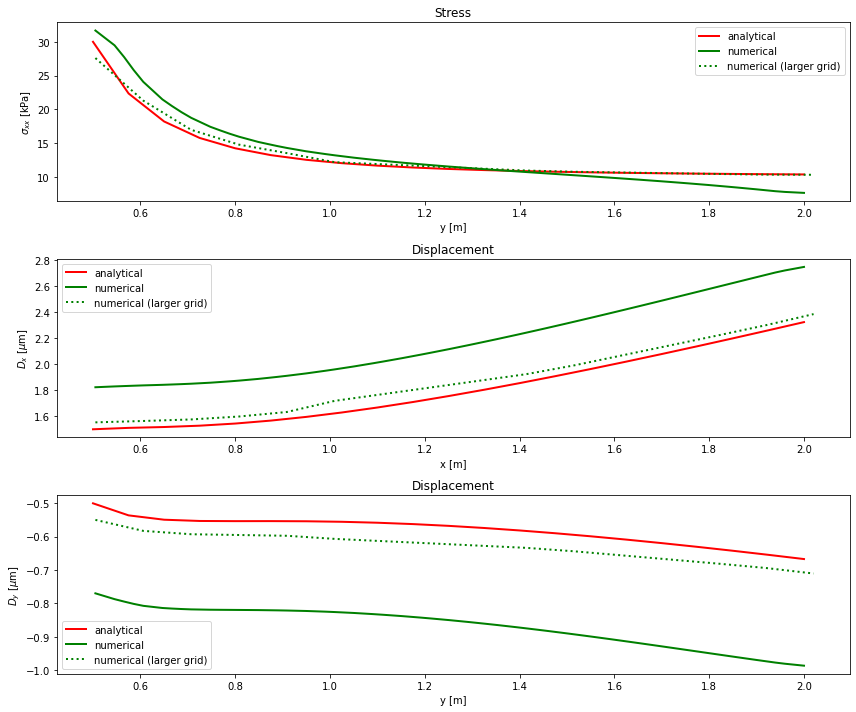

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# calculate analytical data
def sigma_thetatheta(r,theta=90.,T=1e4,a=0.5):
    sigma_thetatheta = T/2*(1 + a**2/r**2) - T*np.cos(2*theta*np.pi/180.)/2 * (3*a**4/r**4 + 1)
    return sigma_thetatheta

def ur(r,theta=90.,T=1e4,E=1e10,nu=0.25,a=0.5):
    ur = (T*r*np.cos(2*theta*np.pi/180.)/2/E * ((1+nu) + 4*a**2/r**2 - (1+nu)*a**4/r**4)
    + T*r/2/E * ((1-nu) + (1+nu)*a**2/r**2))
    return ur
    
# load laplacianFoam postprocessed data
data1x = np.loadtxt('data/PlateWithHole1_x_Dx_Dy_sigmaxx.xy')
data1y = np.loadtxt('data/PlateWithHole1_y_Dx_Dy_sigmaxx.xy')
data2x = np.loadtxt('data/PlateWithHole2_x_Dx_Dy_sigmaxx.xy')
data2y = np.loadtxt('data/PlateWithHole2_y_Dx_Dy_sigmaxx.xy')
#print(data1)

y=np.linspace(0.5,2,21)
fig, axs = plt.subplots(3, 1,figsize=(12,10))
print(axs)
axs[0].set_xlabel('y [m]')
axs[0].set_ylabel('$\sigma_{xx}$ [kPa]')
axs[0].set_title('Stress')
axs[0].plot(y,sigma_thetatheta(y)/1e3,linewidth=2,color='red',label='analytical')
axs[0].plot(data1y[:,1],data1y[:,5]/1e3,linewidth=2,color='green',label='numerical')
axs[0].plot(data2y[:,1][data2y[:,1]<2.1],data2y[:,5][data2y[:,1]<2.1]/1e3,
            linewidth=2,linestyle=':',color='green',label='numerical (larger grid)')
axs[0].legend()

axs[1].set_xlabel('x [m]')
axs[1].set_ylabel('$D_x$ [$\mu$m]')
axs[1].set_title('Displacement')
axs[1].plot(y,ur(y,theta=0)*1e6,linewidth=2,color='red',label='analytical')
axs[1].plot(data1x[:,0],data1x[:,3]*1e6,linewidth=2,color='green',label='numerical')
axs[1].plot(data2x[:,0][data2x[:,0] < 2.1],data2x[:,3][data2x[:,0] < 2.1]*1e6,
            linewidth=2,linestyle=':',color='green',label='numerical (larger grid)')
axs[1].legend()

axs[2].set_xlabel('y [m]')
axs[2].set_ylabel('$D_y$ [$\mu$m]')
axs[2].set_title('Displacement')
axs[2].plot(y,ur(y,theta=90)*1e6,linewidth=2,color='red',label='analytical')
axs[2].plot(data1y[:,1],data1y[:,4]*1e6,linewidth=2,color='green',label='numerical')
axs[2].plot(data2y[:,1][data2y[:,1] < 2.1],data2y[:,4][data2y[:,1] < 2.1]*1e6,
            linewidth=2,linestyle=':',color='green',label='numerical (larger grid)')
axs[2].legend()

plt.tight_layout()

**NOTE: Where does the offset in $u_r$ come from?** From the finite size of the grid.

... done